#### Case Study: Driver Modeling and Analysis: David Choi

A certain ride-sharing company is interested in predicting which driver signups are most likely to start driving. To help explore this question, we have provided a sample dataset of a cohort of driver signups. The data was pulled a few months after they signed up to include the result of whether they actually completed their first trip. It also includes several pieces of background information gather about the driver and their car.

We would like you to use this data set to help understand what factors are best at predicting whether a signup will start to drive, and offer suggestions to operationalize those insights to help the company.

See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. Please also call out any data related assumptions or issues that you encounter.

- Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the driver signups took a first trip?
- Build a predictive model to help this company determine whether or not a driver signup will start driving. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
- Briefly discuss how Uber might leverage the insights gained from the model to generate more first trips (again, a few ideas/sentences will suffice).

Table of Contents:

<a id="Header1"></a> 

[Initial Package Imports and Data Cleaning](#header)

<a id="Header2"></a> 

[Univariate/Bivariate Variable Inspection and Visualization](#header)

<a id="Header3"></a> 

[Feature Selection and Engineering](#header)

<a id="Header4"></a> 

[Predictive Modeling](#header)

<a id="Header5"></a> 

[Final Thoughts](#header)

### Initial Package Imports and Data Cleaning

In [58]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
import os
from scipy.stats import uniform
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [59]:
# Import CSV and Read in the Dataset
driveDf = pd.read_csv("driversData.csv")
driveDf.head(5)
#driveDf.dtypes

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


In [60]:
# Observe Properties of the Dataset. This could include Data Types of Features, # Missing Values, ect.
infoDf = driveDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54681 entries, 0 to 54680
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    54681 non-null  int64  
 1   city_name             54681 non-null  object 
 2   signup_os             47824 non-null  object 
 3   signup_channel        54681 non-null  object 
 4   signup_date           54681 non-null  object 
 5   bgc_date              32896 non-null  object 
 6   vehicle_added_date    13134 non-null  object 
 7   vehicle_make          13223 non-null  object 
 8   vehicle_model         13223 non-null  object 
 9   vehicle_year          13223 non-null  float64
 10  first_completed_date  6137 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.6+ MB


Quick Observations: 
- 54861 Rows, 11 Distinct Features in Dataset.
- Lots of Vehicle Related Information is Missing.
- Casting some datatypes to String, DateTime formats needed.
- Drivers without Background checks can be eliminated, since they violate Terms of Service.

In [61]:
# Data Cleaning and Reformating

# Handle the Timestamps are in the format of M/D/Y, but are not actually a Datetime 
for column in ["signup_date", "bgc_date", "vehicle_added_date", "first_completed_date"]:
    driveDf[column] = pd.to_datetime(driveDf[column]).dt.date    
    
# Reformat Lowercase into Title Format for Readability
driveDf["signup_os"] = driveDf["signup_os"].str.title()

# Drivers that dont have a background check cannot be drivers, so drop where BGC_Date = NaT 
driveDf = driveDf.dropna(subset = ['bgc_date'])
# Drivers that dont have a car cannot be drivers, so drop where vehicle_added_date = NaT
driveDf = driveDf.dropna(subset = ['vehicle_added_date'])

# Indication of null values of certain categories -> new element 
driveDf["vehicle_year"] = driveDf["vehicle_year"].astype(str)
driveDf.loc[driveDf["vehicle_year"] == "nan", "vehicle_year"] = "No Year"
driveDf["vehicle_year"] = np.where(driveDf["vehicle_year"] != "No Year", 
                                   driveDf["vehicle_year"].str[0:4], "No Year")
driveDf.loc[driveDf["vehicle_model"].isna(), "vehicle_model"] = "No Model"
driveDf.loc[driveDf["vehicle_make"].isna(), "vehicle_make"] = "No Maker"

# Renaming of some columns for clarity
driveDf = driveDf.rename(columns = {'id': 'driver_id', "bgc_date": 'background_check_date'})

# Create Target Variable by converting first_completed_date to boolean
driveDf["completed"] = np.where(driveDf["first_completed_date"].isna(), "incomplete", "completed")

# Modified Df Preview. Dimensions of DF (54861, 11) to (32896, 11) after filtering
display(driveDf.head(5), driveDf.shape)

,driver_id,city_name,signup_os,signup_channel,signup_date,background_check_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,completed
3,4,Berton,Android Web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016,2016-02-03,completed
4,5,Strark,Android Web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016,NaT,incomplete
5,6,Strark,Android Web,Referral,2016-01-18,2016-01-18,2016-01-22,Cadillac,DTS,2006,NaT,incomplete
6,7,Strark,Ios Web,Paid,2016-01-14,2016-01-16,2016-01-21,Toyota,Prius V,2014,2016-01-23,completed
10,11,Strark,Ios Web,Referral,2016-01-18,2016-02-09,2016-02-24,Kia,Optima,2015,NaT,incomplete


(12879, 12)

In [62]:
# Make a Dataframe with every Column, Unique Values, and Num Unique Values (for inspection)
dictUnique = {}
for column in driveDf.columns:
    dictUnique[column] = driveDf[column].unique()

dfUnique = pd.DataFrame(list(dictUnique.items()), columns=['Column', 'UniqueValues'])    
dfnumUnique = driveDf.nunique().to_frame().reset_index().rename(
    columns = {'index':'Column', 0:'Number_Unique_Values'})
dfUniques = pd.merge(dfUnique, dfnumUnique, how = 'inner', on = 'Column')
dfUniques

,Column,UniqueValues,Number_Unique_Values
0,driver_id,"[4, 5, 6, 7, 11, 13, 16, 21, 27, 28, 29, 33, 4...",12879
1,city_name,"[Berton, Strark, Wrouver]",3
2,signup_os,"[Android Web, Ios Web, Windows, nan, Mac, Other]",5
3,signup_channel,"[Referral, Paid, Organic]",3
4,signup_date,"[2016-01-29, 2016-01-10, 2016-01-18, 2016-01-1...",30
5,background_check_date,"[2016-02-03, 2016-01-25, 2016-01-18, 2016-01-1...",68
6,vehicle_added_date,"[2016-02-03, 2016-01-26, 2016-01-22, 2016-01-2...",76
7,vehicle_make,"[Toyota, Hyundai, Cadillac, Kia, Dodge, Merced...",46
8,vehicle_model,"[Corolla, Sonata, DTS, Prius V, Optima, Durang...",365
9,vehicle_year,"[2016, 2006, 2014, 2015, 2010, 2012, 2011, 200...",24


Quick Observations:
- Vehicle Model has very high cardinality, might be a redunant feature since vehicle_make is also in the data
- Alternatives to One Hot Encoding needed during data preparation.
- Might be useful to categorize elements within features (buckets, ect) since feature space can quickly expand.
- Target = First_Completed_Date, convert to boolean since we dont care about actual date of completion.
- Number of Observations reduced to 32896 after removing users that are unverified.

### Univariate/Bivariate Variable Inspection and Visualization

   vehicle_year  driver_id
19         2013       1415
20         2014       1618
21         2015       2346
22         2016       1102
23         2017          6


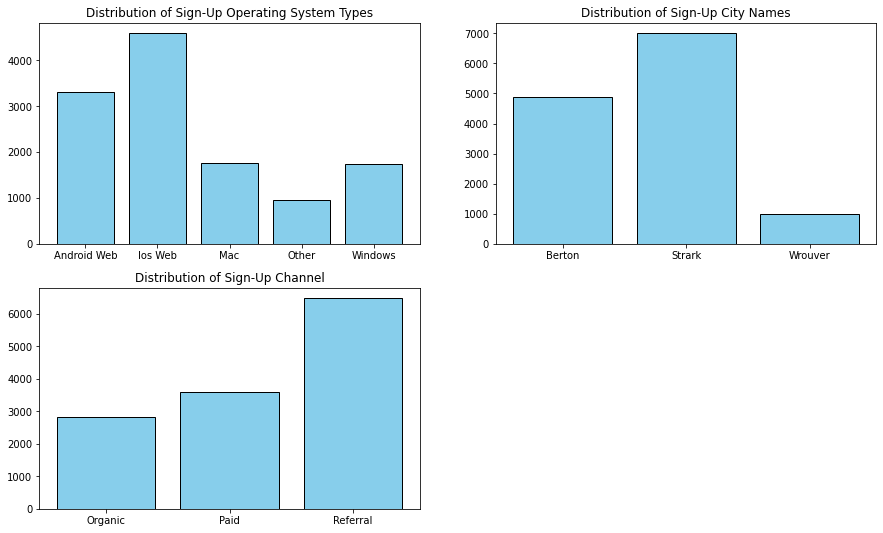

In [63]:
# Visual Inspection of Categorical Columns
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(top=0.8)  

signUps = driveDf.groupby('signup_os')['driver_id'].count().reset_index()
cityName = driveDf.groupby('city_name')["driver_id"].count().reset_index()
signCh = driveDf.groupby('signup_channel')["driver_id"].count().reset_index()
carYear = driveDf.groupby('vehicle_year')["driver_id"].count().reset_index()

axis[0,0].bar(signUps["signup_os"], signUps["driver_id"], color='skyblue', edgecolor='black')
axis[0,0].set_title('Distribution of Sign-Up Operating System Types')

axis[0,1].bar(cityName["city_name"], cityName["driver_id"], color='skyblue', edgecolor='black')
axis[0,1].set_title('Distribution of Sign-Up City Names')

axis[1,0].bar(signCh["signup_channel"], signCh["driver_id"], color='skyblue', edgecolor='black')
axis[1,0].set_title('Distribution of Sign-Up Channel')
fig.delaxes(axis[1, 1])

print(carYear.tail(5))

Empty DataFrame
Columns: [vehicle_make, driver_id]
Index: []
Empty DataFrame
Columns: [vehicle_year, driver_id]
Index: []


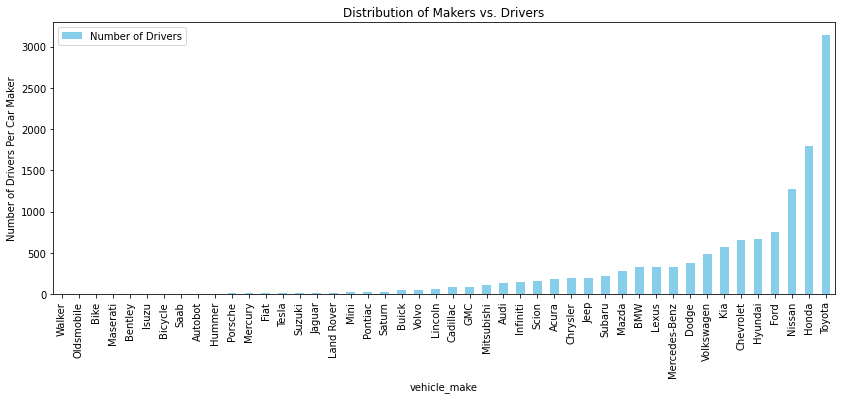

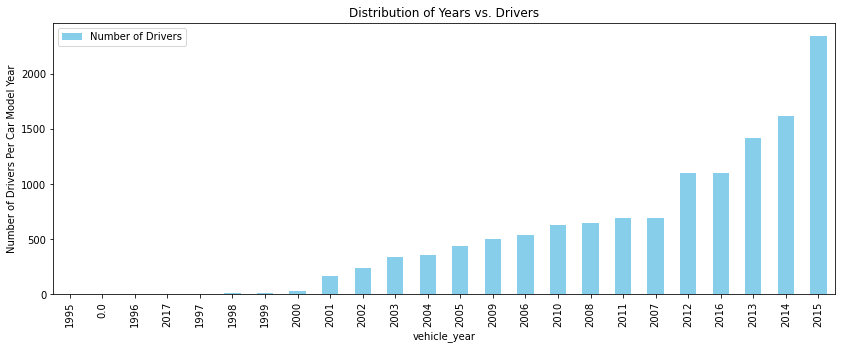

In [64]:
# Visual Inspection of Distribution of Car Makers VS. Num Drivers, Filtered Out "No Maker"
makerDf = driveDf.groupby('vehicle_make')['driver_id'].count().reset_index()
print(makerDf.loc[makerDf["vehicle_make"] == "No Maker"])
makerDf = makerDf.loc[makerDf["vehicle_make"] != "No Maker"]
makerDf = makerDf.sort_values(by = "driver_id").rename(columns = {'driver_id':'Number of Drivers'})
#display(makerDf.head(3), makerDf.tail(3))

# Visual Inspection of Distribution of Car Year VS. Num Drivers, Filtered Out "No Year"
yearDf = driveDf.groupby('vehicle_year')['driver_id'].count().reset_index()
print(yearDf.loc[yearDf["vehicle_year"] == "No Year"])
yearDf = yearDf.loc[yearDf["vehicle_year"] != "No Year"]
yearDf = yearDf.sort_values(by = "driver_id").rename(columns = {'driver_id':'Number of Drivers'})
#display(yearDf.head(3), yearDf.tail(3))

makerDf.plot(x = 'vehicle_make', y = 'Number of Drivers', kind = 'bar', color='skyblue', figsize = (14, 5))
plt.ylabel('Number of Drivers Per Car Maker')
plt.title('Distribution of Makers vs. Drivers')

yearDf.plot(x = 'vehicle_year', y = 'Number of Drivers', kind = 'bar', color='skyblue', figsize = (14, 5))
plt.ylabel('Number of Drivers Per Car Model Year')
plt.title('Distribution of Years vs. Drivers')

# Remove Vehicle_Year 0.0 From Dataset, Incorrect Data w/ low Num Obervations, can be removed
driveDf = driveDf.loc[driveDf['vehicle_year'] != 0.0]

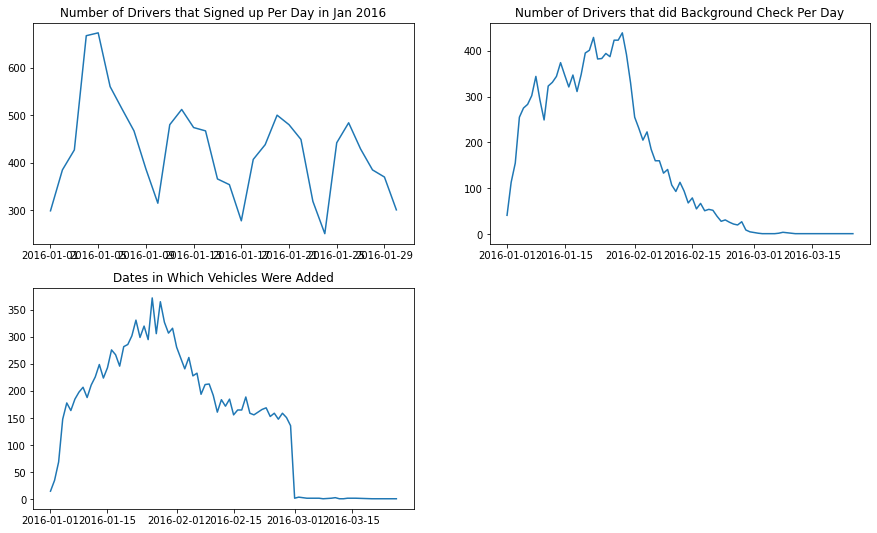

In [65]:
# Visual Inspection of DateTime Columns
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(top=0.8) 

signUpDate = driveDf.groupby('signup_date')['driver_id'].count().reset_index()
bgcDate = driveDf.groupby('background_check_date')['driver_id'].count().reset_index()
vehicleAdded = driveDf.groupby('vehicle_added_date')['driver_id'].count().reset_index()

axis[0,0].plot(signUpDate["signup_date"], signUpDate["driver_id"])
axis[0,0].set_title('Number of Drivers that Signed up Per Day in Jan 2016')

axis[0,1].plot(bgcDate["background_check_date"], bgcDate["driver_id"])
axis[0,1].set_title('Number of Drivers that did Background Check Per Day')

axis[1,0].plot(vehicleAdded["vehicle_added_date"], vehicleAdded["driver_id"])
axis[1,0].set_title('Dates in Which Vehicles Were Added')
fig.delaxes(axis[1, 1])


Quick Observations:
- Overwhelming amount of drivers have no car year (lots of missing data for this feature). Might be worthwhile to consider if Car Year is a feature that may be removed before modeling.
- Ios Web, Android Web have highest count of Sign-Up Types. Overall, many drivers seem to sign up via "Web".
- Most of the sign-ups are people from Strark, with Berton having a significant # of people as well. Perhaps 
- Wrouver might not see many Uber orders, perhaps it is a more walkable city? Maybe it is more dangerous and de-incentivizes drivers from signing up in this specific city? Either way, much less sign ups here.
- Distribution of Sign-Ups lean towards Paid, Referral Types. Perhaps incentivized Sign-Ups are more common, and understandably so.

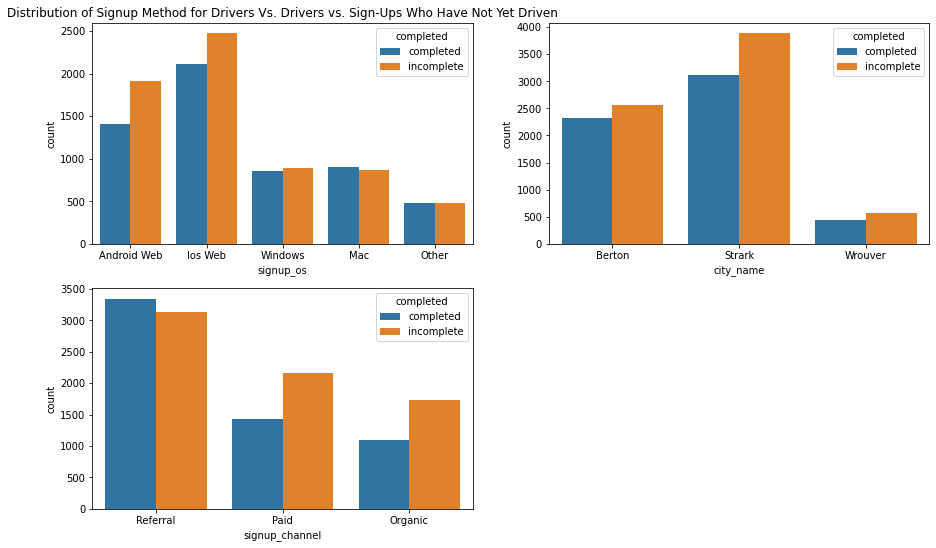

In [66]:
# Plotting Feature Vs. Target - Bivariate Visualization
fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(top=0.8) 

sns.countplot(x = 'signup_os', hue='completed', data = driveDf, ax=axis[0,0])
axis[0,0].set_title('Distribution of Signup OS for Drivers Vs. Drivers vs. Sign-Ups Who Have Not Yet Driven')

sns.countplot(x = 'city_name', hue='completed', data = driveDf, ax=axis[0,1])
axis[0,0].set_title('Distribution of Sign-up Cities for Drivers vs. Sign-Ups Who Have Not Yet Driven')

sns.countplot(x = 'signup_channel', hue='completed', data = driveDf, ax=axis[1,0])
axis[0,0].set_title('Distribution of Signup Method for Drivers Vs. Drivers vs. Sign-Ups Who Have Not Yet Driven')
fig.delaxes(axis[1, 1])

Text(0.5, 1.0, 'Number of Drivers that Completed their first Drive/No Completion VS. Signup Date')

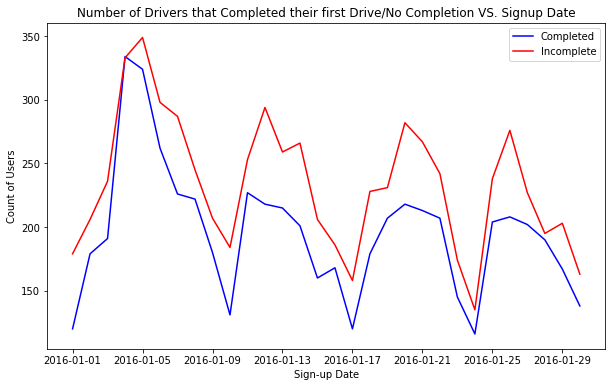

In [67]:
#Signup Dates -> Comparing Number of Signups Per Day -> For Drivers VS
signupComplete = driveDf.loc[driveDf["completed"] == "completed"][["signup_date", "completed"]]
signupComplete = signupComplete.groupby('signup_date')['completed'].count().reset_index()
signupIncomplete = driveDf.loc[driveDf["completed"] == "incomplete"][["signup_date", "completed"]]
signupIncomplete = signupIncomplete.groupby('signup_date')['completed'].count().reset_index()
signupResult = pd.merge(signupComplete, signupIncomplete, on = 'signup_date', how = 'outer')

# Graphing Completed VS Incomplete Per Date 
plt.figure(figsize=(10, 6)) 
plt.plot(signupResult['signup_date'], signupResult['completed_x'], label = 'Completed', color='blue')
plt.plot(signupResult['signup_date'], signupResult['completed_y'], label = 'Incomplete', color='red')
plt.legend()
plt.xlabel('Sign-up Date')
plt.ylabel('Count of Users')
plt.title('Number of Drivers that Completed their first Drive/No Completion VS. Signup Date')

Text(0.5, 1.0, 'Number of Drivers that Completed their first Drive/No Completion VS. Vehicle Added Date')

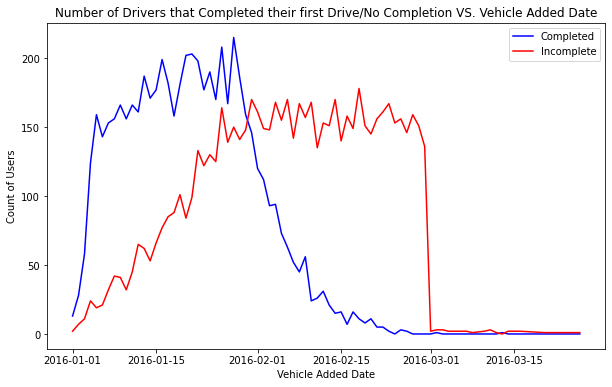

In [68]:
# Vehicle Added Date
vehicleAdded = driveDf.loc[driveDf["completed"] == "completed"][["vehicle_added_date", "completed"]]
vehicleAdded = vehicleAdded.groupby('vehicle_added_date')['completed'].count().reset_index()
vehicleNotAdded = driveDf.loc[driveDf["completed"] == "incomplete"][["vehicle_added_date", "completed"]]
vehicleNotAdded = vehicleNotAdded.groupby('vehicle_added_date')['completed'].count().reset_index()
vehicleResult = pd.merge(vehicleAdded, vehicleNotAdded, on = 'vehicle_added_date', how = 'outer')

# Coalesce NAs from Outer Join to 0
vehicleResult["vehicle_added_date"] = pd.to_datetime(vehicleResult["vehicle_added_date"])
vehicleResult["completed_x"] = vehicleResult["completed_x"].fillna(0)
vehicleResult["completed_y"] = vehicleResult["completed_y"].fillna(0)
vehicleResult = vehicleResult.sort_values(by='vehicle_added_date', ascending=True)
vehicleResult

# Graphing Completed VS Incomplete Per Date 
plt.figure(figsize=(10, 6)) 
plt.plot(vehicleResult['vehicle_added_date'], vehicleResult['completed_x'], label = 'Completed', color='blue')
plt.plot(vehicleResult['vehicle_added_date'], vehicleResult['completed_y'], label = 'Incomplete', color='red')
plt.legend()
plt.xlabel('Vehicle Added Date')
plt.ylabel('Count of Users')
plt.title('Number of Drivers that Completed their first Drive/No Completion VS. Vehicle Added Date')

Quick Observations:
- There are a lot more drivers who have not completed their first drive VS. those who have, but the overarching trends are relatively similar, aside from some differences in the "Sign Up Channel" feature.
- Differences in Tendencies of Vehicle Added Feature - Seems most drivers who have completed their first ride register their vehicles relatively quickly in comparison to those who have not completed an order.
- This could be due to the fact that drivers who quickly register their vehicles are already sure that they want to be Uber Drivers -> Faster Registration means faster access to taking orders. Incompletes may not be sure, so they are not in as much of a rush to do so.

<a id="Header3"></a> 

[Feature Selection and Engineering](#header)

### Feature Selection and Engineering

Since none of the features that will be engineered affect the target variable, there is no risk of data leakage; Therefore, feature engineering before Training and Splitting the data is reasonable in this scenario.

In [69]:
# Feature Engineering to Extract Additional Features from DateTime Columns 

# < 2 Wks Between Signup and BGC = Quick Turnaround, 2Wks < Wks < 1 Month = Moderate Turnaround, Else Long Turnaround
driveDf["BGC_Signup_DateDiff"] = (driveDf["background_check_date"] - driveDf["signup_date"]).dt.days
driveDf["BGC_Signup_DateDiff"] = driveDf["BGC_Signup_DateDiff"].astype(int)
driveDf["BGC_Signup_DateDiff"] = np.where(driveDf["BGC_Signup_DateDiff"] <= 14, "Quick_Turnaround", 
                                  np.where((driveDf["BGC_Signup_DateDiff"] > 14) & 
                                           (driveDf["BGC_Signup_DateDiff"] <= 28), "Moderate_Turnaround", "Slow_Turnaround"))
driveDf.head(5)

,driver_id,city_name,signup_os,signup_channel,signup_date,background_check_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,completed,BGC_Signup_DateDiff
3,4,Berton,Android Web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016,2016-02-03,completed,Quick_Turnaround
4,5,Strark,Android Web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016,NaT,incomplete,Moderate_Turnaround
5,6,Strark,Android Web,Referral,2016-01-18,2016-01-18,2016-01-22,Cadillac,DTS,2006,NaT,incomplete,Quick_Turnaround
6,7,Strark,Ios Web,Paid,2016-01-14,2016-01-16,2016-01-21,Toyota,Prius V,2014,2016-01-23,completed,Quick_Turnaround
10,11,Strark,Ios Web,Referral,2016-01-18,2016-02-09,2016-02-24,Kia,Optima,2015,NaT,incomplete,Moderate_Turnaround


In [70]:
# New Column to get Month of Background Check Date
driveDf["BGC_Month"] = driveDf["background_check_date"].astype(str).str[5:7]
# New Column to get Time Buckets during the Month of Background Check Date (Exact Day may not be of much use)
driveDf["BCG_Day"] = driveDf["background_check_date"].astype(str).str[8:10].astype(int)
driveDf["BCG_Time_ofMonth"] = np.where(driveDf["BCG_Day"] <= 10, "Early_Month",
                              np.where((driveDf["BCG_Day"] > 10) & (driveDf["BCG_Day"] <= 20), "Mid_Month", "Late_Month"))

# New Column to get Month of Vehicle Added Date
driveDf["CarAdded_Month"] = driveDf["vehicle_added_date"].astype(str).str[5:7]
# New Column to get Time Buckets during the Month of Background Check Date (Exact Day may not be of much use)
driveDf["carAdded_Day"] = driveDf["vehicle_added_date"].astype(str).str[8:10].astype(int)
driveDf["carAdded_Time_ofMonth"] = np.where(driveDf["carAdded_Day"] <= 10, "Early_Month",
                                   np.where((driveDf["carAdded_Day"] > 10) & (driveDf["carAdded_Day"] <= 20), 
                                  "Mid_Month", "Late_Month"))
driveDf.head(5)

,driver_id,city_name,signup_os,signup_channel,signup_date,background_check_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date,completed,BGC_Signup_DateDiff,BGC_Month,BCG_Day,BCG_Time_ofMonth,CarAdded_Month,carAdded_Day,carAdded_Time_ofMonth
3,4,Berton,Android Web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016,2016-02-03,completed,Quick_Turnaround,02,3,Early_Month,02,3,Early_Month
4,5,Strark,Android Web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016,NaT,incomplete,Moderate_Turnaround,01,25,Late_Month,01,26,Late_Month
5,6,Strark,Android Web,Referral,2016-01-18,2016-01-18,2016-01-22,Cadillac,DTS,2006,NaT,incomplete,Quick_Turnaround,01,18,Mid_Month,01,22,Late_Month
6,7,Strark,Ios Web,Paid,2016-01-14,2016-01-16,2016-01-21,Toyota,Prius V,2014,2016-01-23,completed,Quick_Turnaround,01,16,Mid_Month,01,21,Late_Month
10,11,Strark,Ios Web,Referral,2016-01-18,2016-02-09,2016-02-24,Kia,Optima,2015,NaT,incomplete,Moderate_Turnaround,02,9,Early_Month,02,24,Late_Month


In [71]:
# Column to get Time Buckets during the Month of Signup (Similar to Other Created Features)
driveDf["signup_Day"] = driveDf["signup_date"].astype(str).str[8:10].astype(int)
driveDf["signup_TimeofMonth"] = np.where(driveDf["signup_Day"] <= 10, "Early_Month",
                                   np.where((driveDf["signup_Day"] > 10) & (driveDf["signup_Day"] <= 20), 
                                  "Mid_Month", "Late_Month"))
driveDf

,driver_id,city_name,signup_os,signup_channel,signup_date,background_check_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,...,completed,BGC_Signup_DateDiff,BGC_Month,BCG_Day,BCG_Time_ofMonth,CarAdded_Month,carAdded_Day,carAdded_Time_ofMonth,signup_Day,signup_TimeofMonth
3,4,Berton,Android Web,Referral,2016-01-29,2016-02-03,2016-02-03,Toyota,Corolla,2016,...,completed,Quick_Turnaround,02,3,Early_Month,02,3,Early_Month,29,Late_Month
4,5,Strark,Android Web,Referral,2016-01-10,2016-01-25,2016-01-26,Hyundai,Sonata,2016,...,incomplete,Moderate_Turnaround,01,25,Late_Month,01,26,Late_Month,10,Early_Month
5,6,Strark,Android Web,Referral,2016-01-18,2016-01-18,2016-01-22,Cadillac,DTS,2006,...,incomplete,Quick_Turnaround,01,18,Mid_Month,01,22,Late_Month,18,Mid_Month
6,7,Strark,Ios Web,Paid,2016-01-14,2016-01-16,2016-01-21,Toyota,Prius V,2014,...,completed,Quick_Turnaround,01,16,Mid_Month,01,21,Late_Month,14,Mid_Month
10,11,Strark,Ios Web,Referral,2016-01-18,2016-02-09,2016-02-24,Kia,Optima,2015,...,incomplete,Moderate_Turnaround,02,9,Early_Month,02,24,Late_Month,18,Mid_Month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54295,54296,Strark,Android Web,Referral,2016-01-24,2016-02-06,2016-02-29,Honda,Civic,2016,...,incomplete,Quick_Turnaround,02,6,Early_Month,02,29,Late_Month,24,Late_Month
54297,54298,Strark,Android Web,Organic,2016-01-14,2016-01-24,2016-02-14,Honda,Accord,2012,...,incomplete,Quick_Turnaround,01,24,Late_Month,02,14,Mid_Month,14,Mid_Month
54298,54299,Berton,Mac,Referral,2016-01-21,2016-01-28,2016-02-09,Honda,CR-V,2015,...,incomplete,Quick_Turnaround,01,28,Late_Month,02,9,Early_Month,21,Late_Month
54303,54304,Strark,Ios Web,Referral,2016-01-02,2016-01-02,2016-01-09,Audi,A6,2011,...,completed,Quick_Turnaround,01,2,Early_Month,01,9,Early_Month,2,Early_Month


In [72]:
# Drop Columns that may not be needed for modeling
finalDf = driveDf.drop(columns = ['driver_id', 'signup_date', 'background_check_date','vehicle_added_date',
                                  'first_completed_date', 'BCG_Day', 'carAdded_Day', 'vehicle_model', 
                                  'signup_Day'])
finalDf.head(5)

,city_name,signup_os,signup_channel,vehicle_make,vehicle_year,completed,BGC_Signup_DateDiff,BGC_Month,BCG_Time_ofMonth,CarAdded_Month,carAdded_Time_ofMonth,signup_TimeofMonth
3,Berton,Android Web,Referral,Toyota,2016,completed,Quick_Turnaround,02,Early_Month,02,Early_Month,Late_Month
4,Strark,Android Web,Referral,Hyundai,2016,incomplete,Moderate_Turnaround,01,Late_Month,01,Late_Month,Early_Month
5,Strark,Android Web,Referral,Cadillac,2006,incomplete,Quick_Turnaround,01,Mid_Month,01,Late_Month,Mid_Month
6,Strark,Ios Web,Paid,Toyota,2014,completed,Quick_Turnaround,01,Mid_Month,01,Late_Month,Mid_Month
10,Strark,Ios Web,Referral,Kia,2015,incomplete,Moderate_Turnaround,02,Early_Month,02,Late_Month,Mid_Month


<a id="Header4"></a> 

[Predictive Modeling](#header)

### Predictive Modeling

In [73]:
# Separate Target Variable from Dataset for Train Test Split
X = finalDf.loc[:, finalDf.columns != "completed"]
y = finalDf[["completed"]]

# Encoding Methods for Categorical Features in Dataset
encodingCol = X.columns.difference(["vehicle_make", "vehicle_year"])
lowCardinality_Col = pd.get_dummies(X[encodingCol], drop_first=True)

# Frequency Encoding High Cardinality Features
highCardinality_Col1 = X['vehicle_year'].value_counts(normalize=True).to_dict()
highCardinality_Col1 = X['vehicle_year'].map(highCardinality_Col1)

highCardinality_Col2 = X['vehicle_make'].value_counts(normalize=True).to_dict()
highCardinality_Col2 = X['vehicle_make'].map(highCardinality_Col2)

highCardinality_Cols = pd.concat([highCardinality_Col1, highCardinality_Col2], axis=1)
X = pd.concat([lowCardinality_Col, highCardinality_Cols], axis = 1)

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head(5)

,BCG_Time_ofMonth_Late_Month,BCG_Time_ofMonth_Mid_Month,BGC_Month_02,BGC_Month_03,BGC_Signup_DateDiff_Quick_Turnaround,BGC_Signup_DateDiff_Slow_Turnaround,CarAdded_Month_02,CarAdded_Month_03,carAdded_Time_ofMonth_Late_Month,carAdded_Time_ofMonth_Mid_Month,...,signup_TimeofMonth_Late_Month,signup_TimeofMonth_Mid_Month,signup_channel_Paid,signup_channel_Referral,signup_os_Ios Web,signup_os_Mac,signup_os_Other,signup_os_Windows,vehicle_year,vehicle_make
31886,0,1,0,0,1,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0.018790,0.050858
29473,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0.085566,0.051557
22996,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.125631,0.243575
560,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0.109869,0.243575
4472,0,0,1,0,0,0,1,0,1,0,...,0,1,1,0,1,0,0,0,0.109869,0.011181


In [74]:
# Train Baseline Model - Random Forest Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)

# Train Model on Training Set
y_pred_train = dt_classifier.predict(X_train)
accuracyTrain = accuracy_score(y_train, y_pred_train)
print("Random Forest Accuracy with No Tuning on Training Set: " + str(accuracyTrain))

# Train Model on Test Set
y_pred_test = dt_classifier.predict(X_test)
accuracyTest = accuracy_score(y_test, y_pred_test)
print("Random Forest Accuracy with No Tuning on Test Set: " + str(accuracyTest))

Random Forest Accuracy with No Tuning on Training Set: 0.9653498980879356
Random Forest Accuracy with No Tuning on Test Set: 0.6956521739130435


Started with a Baseline model (Decision Tree). Since there is a noticeable difference between the accuracy of predictions of the training set VS. the test set, it is clear that Decision Trees overfit on this training data (Due to the characteristics of Decision Trees, one wrong split at a node can lead to vastly different classification results. It is highly likely that Decision Trees pick up characteristics evident only in the training data, causing it to incorrectly split at nodes when testing on holdout data, leading to high bias and overfitting). We can try a model that is more robust to overfitting as a starting point, and further attempt to increase test accuracy to ensure model performs well on unseen datasets.

In [75]:
# Alleviating Overfitting with Boosting Algorithm
adaBoost = AdaBoostClassifier(n_estimators=50, random_state=42)

# Training Model on Training Set
adaBoost.fit(X_train, y_train)
y_pred_train = adaBoost.predict(X_train)
accuracyTrain = accuracy_score(y_train, y_pred_train)
print("AdaBoost Accuracy with No Tuning on Training Set: " + str(accuracyTrain))

# Train Model on Test Set
y_pred_test = adaBoost.predict(X_test)
accuracyTest = accuracy_score(y_test, y_pred_test)
print("AdaBoost Accuracy with No Tuning on Test Set: " + str(accuracyTest))

AdaBoost Accuracy with No Tuning on Training Set: 0.7671551975152868
AdaBoost Accuracy with No Tuning on Test Set: 0.7787267080745341


We can utilize Ensembling Methods in lieu of "traditional" classification models, as it is evident that there is both high bias and high variance (Low Test Accuracy, High Difference between Training and Test Accuracies). In particular, boosting would be a good approach to handle overfitting, as it involves the sequential training of "weak learners" (e.g Decision Stumps), which are characterized to have high bias but low variance (due to the low model complexity of these weak learners). By sequentially training weak learners, the model will converge towards one with low bias, while maintaining low variance as characterized by Decision Stumps (AdaBoost Method).

As expected, overfitting does not occur with Ensembling anymore, and the bias of the Model has also decreased, although there is still margin for improvement.

In [76]:
# Determine which Features impact the model. 
importanceValues = adaBoost.feature_importances_
colNames = X_train.columns.values.tolist()
importanceValues = sorted(importanceValues)
print(importanceValues)

[0.0, 0.0, 0.0, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.04, 0.06, 0.06, 0.06, 0.08, 0.08, 0.1, 0.16, 0.16]


We can utilize feature_importances in order to determine if there are any "noisy" or irrelevant features that may negatively affect model performance (or redundant features that while dont negatively affect a model, do make it more complex which leads to the risk of overfitting)

It is important to note for Feature_Importances that the dataset used for training is Encoded. We cannot remove Cols based on this value alone (aside from Target Encoded Features), as there may be information loss and the original meaning of the feature may be lost if subsections of One-Hot Encoded Columns are omitted/changed. 

<AxesSubplot:>

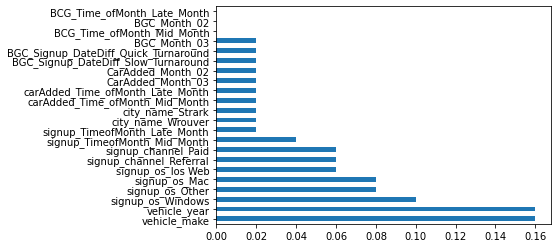

In [77]:
# Plot Feature Importances
feat_importances = pd.Series(importanceValues, index = colNames)
feat_importances.nlargest(22).plot(kind='barh')

In [55]:
# Since feature_Importances is already normalized, no further treatment required
feat_importances

BCG_Time_ofMonth_Late_Month             0.00
BCG_Time_ofMonth_Mid_Month              0.00
BGC_Month_02                            0.00
BGC_Month_03                            0.02
BGC_Signup_DateDiff_Quick_Turnaround    0.02
BGC_Signup_DateDiff_Slow_Turnaround     0.02
CarAdded_Month_02                       0.02
CarAdded_Month_03                       0.02
carAdded_Time_ofMonth_Late_Month        0.02
carAdded_Time_ofMonth_Mid_Month         0.02
city_name_Strark                        0.02
city_name_Wrouver                       0.02
signup_TimeofMonth_Late_Month           0.02
signup_TimeofMonth_Mid_Month            0.04
signup_channel_Paid                     0.06
signup_channel_Referral                 0.06
signup_os_Ios Web                       0.06
signup_os_Mac                           0.08
signup_os_Other                         0.08
signup_os_Windows                       0.10
vehicle_year                            0.16
vehicle_make                            0.16
dtype: flo

In [78]:
# Dropping some unimpactful Columns (Relating to Background Date based on Feature_Importances)
# When dropping a "Column", need to remove all One Hot Encoded Cols that stem from the original Column
X_Train = X_train.drop(columns = ['BCG_Time_ofMonth_Late_Month', 'BCG_Time_ofMonth_Mid_Month', 'BGC_Month_02', 
                                 'BGC_Month_03'])
X_Test = X_test.drop(columns = ['BCG_Time_ofMonth_Late_Month', 'BCG_Time_ofMonth_Mid_Month', 'BGC_Month_02', 
                                 'BGC_Month_03'])

Simple Hyperparameter Tuning will be done at the end to marginally reduce any chances of overfitting and find the most "optimal" hyperparameters for the model. We will pick a Hyperparameter Tuning technique that gives us a good middle ground between effectiveness and computational speed, as many techniques may be exhaustive and time consuming.

In [29]:
# Hyperparameter Tuning with Randomized Search 
param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': uniform(0.1, 1.0)
}

random_search = RandomizedSearchCV(adaBoost, param_distributions = param_dist, n_iter=10, cv = 5, random_state = 42)
random_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = random_search.best_params_
{'learning_rate': 0.7174815096277165, 'n_estimators': 100}

# Implementing Optimal Hyperparameters back into AdaBoost for Optimized Output
adaBoost = AdaBoostClassifier(n_estimators=50, random_state=42)
best_ada_boost = random_search.best_estimator_
accuracy = best_ada_boost.score(X_test, y_test)
print("Accuracy after Hyperparamter Tuning: " + str(accuracy))

# Significant Improvements from Baseline Test Accuracy, but room for improvement in terms of bias.

0.781055900621118


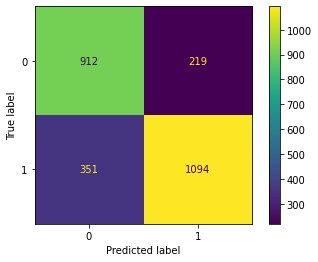

In [80]:
# Simple Confusion Matrix for More Detailed Metrics
cm = metrics.confusion_matrix(y_test, y_pred_test)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
cm_display.plot()

Interpretation: 
- (0,0) = True Positive (Sensitivity / Recall): Number of Positives that are accurately classified 
- (0,1) = False Positive (Type I Error)
- (1,0) = False Negative (Type II Error): Number of Observations that were classified as Negative but Actually Positive
- (1,1) = True Negative (Specificity): Number of Negatives that are accurately classified as Negative

In [81]:
# Closer Inspection of Metrics
tp, fp, fn, tn = cm.ravel() # Flatten CM ([[], []]) to one dimensional array
sensitivity = tp / (tp + fn) # Number of Positives Accurately Classified out of all total Positives
type1 = fp / (fp + tn) # Number of Misclassified Positives that were actually Negatives
type2 = fn / (fn + tp) # Number of Misclassified Negatives that were actually Positives
specificity = tn / (tn + fp) # Number of Negatives Accurately Classified out of all total Negatives

print("Sensitivity: " + str(sensitivity))
print("Type I Error/False Positive Rate: " + str(type1))
print("Type II Error/False Negative Rate: " + str(type2))
print("Specificity: " + str(specificity))

# Precision is important when false positives can be costly (which is not in this case)
precision = tp / (tp + fp)
# Sensitivity/Recall is important when false negatives can be costly

Sensitivity: 0.7220902612826603
Type I Error/False Positive Rate: 0.1667936024371668
Type II Error/False Negative Rate: 0.27790973871733965
Specificity: 0.8332063975628332



- Debated whether respecting the ratio of classes in training and test set separation (or Stratified K-Fold Cross Validation if overfitting was evident), but the differences in count of the classes were not as big enough to warrant this.
- Implemented a Confusion Matrix and Considered metrics such as Precision and Recall. However, in this business case, the consequences of Type II error VS. Type I error is not as large, and the lack of a large class imbalance (as well as other factors) make me believe that there will not be a significant difference in these metrics.
- Since Data is Tabular and not considered "Big Data", traditional approaches such as Tree-Based Methods, as well as more reliable methods such as Ensembling would suffice. In fact, although I debated using more complex deep learning methods (such as a simple Multi-Layer Perceptron and ANN model), the black-box nature of such models as well as the nature of the data leads me to believe that traditional models will perform better and take less time to execute. Explainability > Accuracy in this case
- ROC Curve may be redundant in this model example, so I excluded it, as there is a good understanding of model distinguishability.

Final Thoughts and Takeaways:
- Adding greater incentives for first-time drivers may allow the company to see more drivers that actually complete their first order, since most drivers sign up through Referral or Paid Offers, and much less drivers organically sign up.
- The majority of Sign ups occur through "Web", such as "IOS Web". However, sign-ups through web (or through web on the phone) might be a hastle, especially considering the existence of the rideshare App, and the fact that most drivers use their phones a lot more frequently compared to Websites when outside. Introducing an easier method of sign-ups via mobile methodology may incentivize first-time drivers through convenience.
- Most Drivers who complete first-time orders typically do so quickly, as evidenced by visualization. Incentivizing quick sign-ups and order completions might help the company retain its current drivers and the rate of first time drivers, while also nudging other drivers (who may be on the fence about becoming a driver) to at least try an order, potentially adding new drivers to the driver pool and increasing the % of drivers who sign up and take at least one order.
- Car Maker Year is an important feature that is used to drive accuracy in the Adaboost model. This may be due to multiple factors (e.g Newer Cars have better MPG, allowing drivers to take more orders and incentivizing them, Newer Cars are safer and thus get more orders and better paying rides, ect)
